/Users/owl/py314/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/owl/py314/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/owl/py314/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/owl/py314/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for for

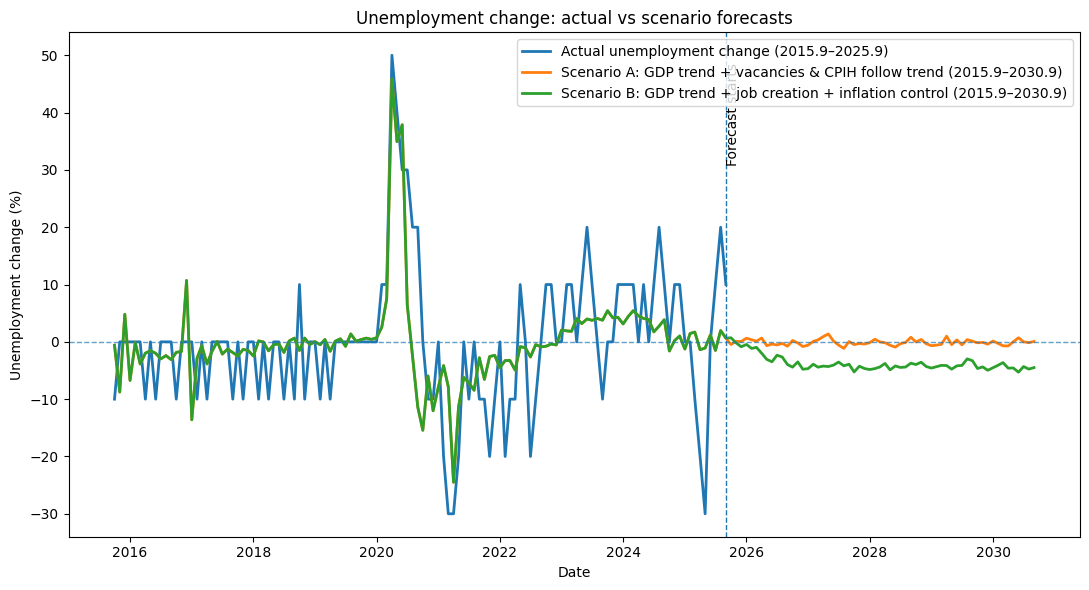

Saved: pic/Scenario_forecast_unemployment_change_2015_2030.png


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

# 固定随机种子（让每次画出来的线都一样）
rng = np.random.default_rng(42)

# =============================
# 0. 路径 & 输出文件夹
# =============================
PATH_UNEMP = "using_data_csv/失业率（15-25）.csv"
PATH_VAC   = "using_data_csv/职位空缺（15-25）.csv"
PATH_GDP   = "using_data_csv/GDP指数（15-25）.csv"
PATH_CPIH  = "using_data_csv/CPIH消费者物价指数（15-25）.csv"
PATH_RATE  = "using_data_csv/银行利率（15-25）.csv"

os.makedirs("pic", exist_ok=True)

# =============================
# 1. 读取数据（统一列名）
# =============================
unemp = pd.read_csv(PATH_UNEMP, parse_dates=["date"]).rename(columns={"rate": "unemployment"})
vac   = pd.read_csv(PATH_VAC,   parse_dates=["date"]).rename(columns={"value": "vacancies"})
gdp   = pd.read_csv(PATH_GDP,   parse_dates=["date"]).rename(columns={"value": "gdp_index"})
cpih  = pd.read_csv(PATH_CPIH,  parse_dates=["date"]).rename(columns={"value": "cpih"})
rate  = pd.read_csv(PATH_RATE,  parse_dates=["date"]).rename(columns={"value": "interest_rate"})

# =============================
# 2. 合并 + 排序
# =============================
df = (
    unemp.merge(vac, on="date", how="inner")
         .merge(gdp, on="date", how="inner")
         .merge(cpih, on="date", how="inner")
         .merge(rate, on="date", how="inner")
         .dropna()
         .sort_values("date")
         .reset_index(drop=True)
)

# =============================
# 3. 构造变化/增长变量
# =============================
df["unemployment_change"] = df["unemployment"].diff() * 100
df["vacancies_growth"]    = df["vacancies"].pct_change() * 100
df["gdp_growth"]          = df["gdp_index"].pct_change() * 100
df["cpih_inflation"]      = df["cpih"].pct_change() * 100
df["interest_change"]     = df["interest_rate"].diff()   # 不进模型

df_ts = df.dropna().copy()

# =============================
# 4. 拟合回归模型（OLS）
# unemployment_change ~ vacancies_growth + gdp_growth + cpih_inflation
# =============================
X = sm.add_constant(df_ts[["vacancies_growth", "gdp_growth", "cpih_inflation"]])
y = df_ts["unemployment_change"]
model = sm.OLS(y, X).fit()

# =============================
# 5. AR(1) 点预测函数（用于外推自变量）
# =============================
def ar1_forecast(series: pd.Series, steps: int):
    s = series.dropna().astype(float)
    if len(s) < 10:
        return np.repeat(s.mean(), steps)
    ar1 = AutoReg(s, lags=1, trend="c", old_names=False).fit()
    return ar1.predict(start=len(s), end=len(s) + steps - 1)

# =============================
# 6. 情景预测：2015.9–2030.9
# =============================

# 6.1 时间轴：到 2030-09（和图一致）
start_date = df_ts["date"].min()
end_hist = df_ts["date"].max()           # 历史结束（大概 2025-09-01）
end_future = pd.Timestamp("2030-09-01")  # 预测截止

dates_full = pd.date_range(start=start_date, end=end_future, freq="MS")
df_full = pd.DataFrame({"date": dates_full})

# 历史自变量合并进来
hist_vars = df_ts[["date", "vacancies_growth", "gdp_growth", "cpih_inflation"]].copy()
df_full = df_full.merge(hist_vars, on="date", how="left")

future_mask = df_full["date"] > end_hist
n_future = future_mask.sum()

# 6.2 GDP：未来用 AR(1) 外推
gdp_base_fc = ar1_forecast(df_ts["gdp_growth"], n_future)
df_full.loc[future_mask, "gdp_growth"] = gdp_base_fc

# 6.3 基准情景：vacancies / CPIH = AR(1) + 小噪声
vac_base_fc  = ar1_forecast(df_ts["vacancies_growth"],  n_future)
cpih_base_fc = ar1_forecast(df_ts["cpih_inflation"],   n_future)

# 噪声强度可以自己调，小一点线就更平滑
noise_std_vac  = 0   # 岗位增长噪声
noise_std_cpih = 0   # 通胀噪声

vac_base_fc_noisy  = vac_base_fc  + rng.normal(0, noise_std_vac,  n_future)
cpih_base_fc_noisy = cpih_base_fc + rng.normal(0, noise_std_cpih, n_future)

df_full.loc[future_mask, "vacancies_growth_base"]  = vac_base_fc_noisy
df_full.loc[future_mask, "cpih_inflation_base"]    = cpih_base_fc_noisy

# 历史期用真实值
df_full.loc[~future_mask, "vacancies_growth_base"] = df_full.loc[~future_mask, "vacancies_growth"]
df_full.loc[~future_mask, "cpih_inflation_base"]   = df_full.loc[~future_mask, "cpih_inflation"]

# 6.4 政策情景：提升 vacancies、压低 CPIH（平滑过渡）
vac_target  = np.nanpercentile(df_ts["vacancies_growth"].dropna(), 90)  # 就业“偏强”
cpih_target = 0.0  # 通胀控制到 0 左右

transition_months = 12  # 政策逐步实施的过渡期（月）

vac_start  = float(df_full.loc[future_mask, "vacancies_growth_base"].iloc[0])
cpih_start = float(df_full.loc[future_mask, "cpih_inflation_base"].iloc[0])

t = np.arange(n_future)
w = np.clip(t / transition_months, 0, 1)  # 0→1 的过渡权重

vac_policy_fc  = (1 - w) * vac_start  + w * vac_target
cpih_policy_fc = (1 - w) * cpih_start + w * cpih_target

df_full.loc[future_mask, "vacancies_growth_policy"] = vac_policy_fc
df_full.loc[future_mask, "cpih_inflation_policy"]   = cpih_policy_fc

# 历史期政策 = 真实值（保证历史阶段两条线重合）
df_full.loc[~future_mask, "vacancies_growth_policy"] = df_full.loc[~future_mask, "vacancies_growth"]
df_full.loc[~future_mask, "cpih_inflation_policy"]   = df_full.loc[~future_mask, "cpih_inflation"]

# 6.5 用回归模型生成两条预测失业率变化
# baseline
X_base = df_full[["vacancies_growth_base", "gdp_growth", "cpih_inflation_base"]].rename(
    columns={
        "vacancies_growth_base": "vacancies_growth",
        "cpih_inflation_base": "cpih_inflation",
    }
)
X_base = sm.add_constant(X_base, has_constant="add")
df_full["unemp_change_pred_base"] = model.predict(X_base)

base_y_noise_std = 0.5
df_full.loc[future_mask, "unemp_change_pred_base"] = (
    df_full.loc[future_mask, "unemp_change_pred_base"]
    + rng.normal(0, base_y_noise_std, n_future)
)

# policy
X_policy = df_full[["vacancies_growth_policy", "gdp_growth", "cpih_inflation_policy"]].rename(
    columns={
        "vacancies_growth_policy": "vacancies_growth",
        "cpih_inflation_policy": "cpih_inflation",
    }
)
X_policy = sm.add_constant(X_policy, has_constant="add")
df_full["unemp_change_pred_policy"] = model.predict(X_policy)

policy_y_noise_std = 0.5
df_full.loc[future_mask, "unemp_change_pred_policy"] = (
    df_full.loc[future_mask, "unemp_change_pred_policy"]
    + rng.normal(0, policy_y_noise_std, n_future)
)


# =============================
# 7. 画图：三条折线（和你截图类似）
# =============================
plt.figure(figsize=(11, 6))

# 实际
plt.plot(
    df_ts["date"],
    df_ts["unemployment_change"],
    label="Actual unemployment change (2015.9–2025.9)",
    linewidth=2,
)

# 情景 A：趋势延续
plt.plot(
    df_full["date"],
    df_full["unemp_change_pred_base"],
    label="Scenario A: GDP trend + vacancies & CPIH follow trend (2015.9–2030.9)",
    linewidth=2,
)

# 情景 B：政策路径
plt.plot(
    df_full["date"],
    df_full["unemp_change_pred_policy"],
    label="Scenario B: GDP trend + job creation + inflation control (2015.9–2030.9)",
    linewidth=2,
)

# 水平 0 线
plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)

# 竖线：预测起点
plt.axvline(end_hist, linestyle="--", linewidth=1)
plt.text(end_hist, plt.ylim()[1] * 0.9, "Forecast starts", rotation=90, va="top")

plt.xlabel("Date")
plt.ylabel("Unemployment change (%)")
plt.title("Unemployment change: actual vs scenario forecasts")
plt.legend()
plt.tight_layout()

out_path = "pic/Scenario_forecast_unemployment_change_2015_2030.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved: {out_path}")
